In [2]:
import numpy as np
import pandas as pd
import re
import yfinance as yf

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

In [7]:
returns_columns = ["1MReturn","3MReturn","6MReturn","12MReturn"]

Importing data

In [4]:
convictions_and_returns = pd.read_csv('convictions_and_returns.csv')  

In [6]:
## formating date
convictions_and_returns['DATE'] = pd.to_datetime(
                          convictions_and_returns['DATE'],
                          format='%Y-%m-%d')

In [8]:
## sorting
convictions_and_returns = convictions_and_returns.sort_values(by="DATE")

In [9]:
# replace -1 with nan in Returns columns
convictions_and_returns[returns_columns] = convictions_and_returns[returns_columns].replace({'-1':np.nan, -1:np.nan})

In [10]:
# drop duplicated index

convictions_and_returns.drop(['Unnamed: 0'],axis=1, inplace=True)

are some rows duplicated?

In [11]:
convictions_and_returns.columns

Index(['DATE', 'ID', 'STOCK', 'SECTOR', 'TYPE', 'SCORE', 'TIME', '1MReturn',
       '3MReturn', '6MReturn', '12MReturn'],
      dtype='object')

In [12]:
convictions_and_returns.duplicated().sum()

0

How many stocks dont have any ratings

In [13]:
is_all_null_per_stock = convictions_and_returns.groupby('STOCK')['SCORE'].apply(lambda x: x.isnull().all()).to_frame()
all_null_per_stock_count = is_all_null_per_stock['SCORE'].value_counts().to_frame()
all_null_per_stock_count.reset_index(inplace=True)
all_null_per_stock_count.columns = ['VALUE', 'COUNT']

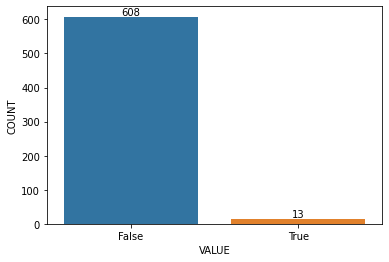

In [14]:
ax = sns.barplot(x='VALUE', y='COUNT', data=all_null_per_stock_count)
ax.bar_label(ax.containers[0])
plt.show()

Companies whitout any ratings can be deleted. There is nothing more to analyze

In [15]:
# deleting companies without any ratings
companies_without_scores = is_all_null_per_stock.loc[is_all_null_per_stock['SCORE'] == True]
companies_without_scores.reset_index(inplace=True)
companies_without_score = companies_without_scores['STOCK'].to_list()

In [16]:
convictions_and_returns = convictions_and_returns[~convictions_and_returns['STOCK'].isin(companies_without_score)]

Duplicated values in-depth analysis

In [17]:
convictions_and_returns.duplicated(subset=["STOCK","DATE"]).sum()

115

In [18]:
convictions_and_returns.duplicated(subset=["STOCK","DATE","SCORE"]).sum()

115

The duplicated rows can be removed, because more or two scores for the same date and stock dont bring any new information

In [19]:
convictions_and_returns.drop_duplicates(subset=["STOCK","DATE","SCORE"],keep="first",inplace=True)

In [38]:
## save deduplicated convictions and returns without companies with no convictions

convictions_and_returns.to_csv('convictions_and_returns_cleaned.csv')

How many Stocks have at least one missing score?

In [20]:
is_any_null_per_stock = convictions_and_returns.groupby('STOCK')['SCORE'].apply(lambda x: x.isnull().any()).to_frame()

In [21]:
any_null_per_stock_count = is_any_null_per_stock['SCORE'].value_counts().to_frame()
any_null_per_stock_count.reset_index(inplace=True)
any_null_per_stock_count.columns = ['VALUE', 'COUNT']

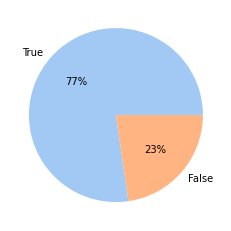

In [22]:
plt.pie(any_null_per_stock_count['COUNT'], labels = any_null_per_stock_count['VALUE'], colors = colors, autopct='%.0f%%')
plt.show()

Almost 80 percent of companies have at least one measing value when it comes to score

Which Percent of Returns are missing

In [23]:
percent_missing = convictions_and_returns[returns_columns].isnull().sum() * 100 / len(convictions_and_returns)

In [24]:
percent_missing

1MReturn     0.164745
3MReturn     0.114605
6MReturn     0.100279
12MReturn    4.440943
dtype: float64

How many companies dont have any returns?

In [25]:
is_all_returns_null_per_stock = convictions_and_returns.groupby('STOCK')[returns_columns].apply(lambda x: x.isnull().all())
is_all_returns_per_stock_count = is_all_returns_null_per_stock[returns_columns].value_counts()

In [26]:
is_all_returns_per_stock_count

1MReturn  3MReturn  6MReturn  12MReturn
False     False     False     False        608
dtype: int64

 there is no companies left witch dont have any 

Consequtives nans for each company

In [27]:
list_of_companies = convictions_and_returns["STOCK"].unique()
list_of_dates = convictions_and_returns["DATE"].unique()

In [28]:
def extract_nan_statistics(df, list_of_companies):
    nulls = pd.DataFrame(columns=["STOCK","NAN number",'Consequtive NAN max' ])
    for l in list_of_companies:
        stock_data = df.loc[df['STOCK'] == l]
        temp = stock_data.SCORE.isnull().astype(int).groupby(stock_data.SCORE.notnull().astype(int).cumsum()).sum() ## consequtives nans
        nulls.loc[len(nulls.index)] = [l, temp.sum(), temp.max()]
        
    return nulls


In [29]:
nulls = extract_nan_statistics(convictions_and_returns, list_of_companies)

In [30]:
nulls_max_value_counts = nulls['Consequtive NAN max'].value_counts().to_frame()
nulls_max_value_counts.reset_index(inplace = True)

In [31]:
nulls_max_value_counts.columns

Index(['index', 'Consequtive NAN max'], dtype='object')

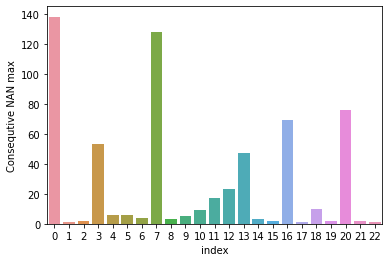

In [32]:
ax = sns.barplot(x="index", y="Consequtive NAN max", data=nulls_max_value_counts)
plt.show()

In [33]:
print(len(list_of_dates))

23


Which part of nans is only one period specific?

In [34]:
nulls['one period only'] = np.where(nulls['NAN number']== nulls["Consequtive NAN max"], True, False)

In [35]:
is_nan_one_period_only_count = nulls['one period only'].value_counts().to_frame()
is_nan_one_period_only_count.reset_index(inplace=True)
is_nan_one_period_only_count.columns = ['VALUE', 'COUNT']

In [36]:
is_nan_one_period_only_count

,VALUE,COUNT
0,True,529
1,False,79


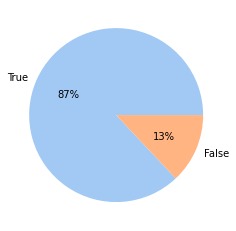

In [37]:
plt.pie(is_nan_one_period_only_count['COUNT'], labels = is_nan_one_period_only_count['VALUE'], colors = colors, autopct='%.0f%%')
plt.show()